In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score


from task_4_core.hopfield import Hopfield 

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [3]:
def binarize(threshold, data):
    return np.where(data > threshold, 1, -1)

In [4]:
def get_input(threshold, class_count):
    train_index = np.where(train_labels < class_count)
    train_images_binarized = binarize(threshold, train_images).reshape(train_images.shape[0], train_images.shape[1] * train_images.shape[2])
    
    test_index = np.where(test_labels < class_count)
    test_images_binarized = binarize(threshold, test_images).reshape(test_images.shape[0], test_images.shape[1] * test_images.shape[2])

    return (train_images_binarized[train_index], train_labels[train_index]), (test_images_binarized[test_index], test_labels[test_index])

In [6]:
def train_and_visualize(train, test, classes, hide_charts = False, test_len=20, references_per_class=1, learning_rule='hebb', energy_function='classic', update_function='sync', threshold=0):
    
    references = list(map(lambda n: train[0][np.where(train[1] == n)[0]][:references_per_class], classes))
    references = np.array(references).reshape(len(classes) * references_per_class, 784)
    print(references.shape)
    
    model = Hopfield((28, 28))
    model.train_weights(references, learning_rule)
    predictions = []
    
    for i in range(test_len):
        label = test[1][i]
        image = test[0][i]
        predicted = model.predict([image], 1, threshold=threshold, energy_function=energy_function, update_function=update_function)[0]
        
        # somehow storkey is inverted after the full sync update
        if learning_rule == 'storkey' and update_function == 'sync':
            predicted = -np.sign(predicted)

        reference_similarities = list(map(lambda ref: np.count_nonzero(ref == predicted), references))
        prediction = reference_similarities.index(max(reference_similarities))
        prediction_label = prediction // references_per_class
        predictions.append(prediction_label)
        
        if not hide_charts:
            print(f'Predicted value = {prediction}, actual label = {label}')
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4)
            fig.tight_layout(pad=1.0)
            ax1.imshow(references[label * references_per_class].reshape(28, 28), cmap='Greys',  interpolation='nearest')
            ax1.set_title("Memory")
            ax2.imshow(image.reshape(28, 28), cmap='Greys',  interpolation='nearest')
            ax2.set_title("Input")
            ax3.imshow(predicted.reshape(28, 28), cmap='Greys',  interpolation='nearest')
            ax3.set_title("Output")
            ax4.imshow(references[prediction].reshape(28, 28), cmap='Greys',  interpolation='nearest')
            ax4.set_title("Closest memory")
            plt.show()
            
    test_metrics = test[1][:test_len]
    metrics = (
        accuracy_score(test_metrics, predictions),
        f1_score(test_metrics, predictions, average='macro'),
        recall_score(test_metrics, predictions, average='macro', zero_division=0),
        precision_score(test_metrics, predictions, average='macro', zero_division=0)
    )
    return metrics

### General parameters analysis

In [7]:
classes_count = range(2, 11)
threshold = range(0, 101, 10)
energy_funcs = ['exp', 'classic']
update_funcs = ['sync', 'async', 'demircigil']
learning_rules = ['hebb', 'storkey', 'demircigil']

demircigil_product = set(itertools.product(classes_count, ['exp'], ['demircigil'], ['demircigil']))
classic_product = set(itertools.product(classes_count, ['classic', 'exp'], ['sync', 'async'], ['hebb', 'storkey']))
result_product = demircigil_product.union(classic_product)
result = itertools.product(threshold, result_product)

def labels_metrics():
    return {label: {} for label in classes_count}

def update_metrics(): 
    return {update: labels_metrics() for update in update_funcs}

def energy_metrics():
    return {energy: update_metrics() for energy in energy_funcs}

history = {rule: energy_metrics() for rule in learning_rules}

# SET HIDE_CHARTS TO FALSE TO ENABLE CHARTS ON LINE 19
for threshold, (classes_used, energy, update, rule) in result:
    train, test = get_input(threshold, classes_used)
    classes = list(np.unique(train[1]))
    
    print(f'Using threshold - {threshold}')
    print(f'Using {classes_used} classes, {energy} energy func, {update} update method and {rule} learning rule')
    
    metrics = train_and_visualize(train, test, classes, test_len=100, hide_charts=True, learning_rule=rule, energy_function=energy, update_function=update, threshold=threshold)
    history[rule][energy][update][classes_used][threshold] = metrics

    print(f'Metrics:\nAccuracy - {metrics[0]},\nF1 - {metrics[1]},\nRecall - {metrics[2]},\nPrecision - {metrics[3]}')
    print('------------------------------------\n\n\n')

Using threshold - 0
Using 3 classes, classic energy func, sync update method and hebb learning rule
(3, 784)
Metrics:
Accuracy - 0.57,
F1 - 0.4948914431673052,
Recall - 0.54,
Precision - 0.73
------------------------------------



Using threshold - 0
Using 2 classes, exp energy func, sync update method and storkey learning rule
(2, 784)
Metrics:
Accuracy - 0.99,
F1 - 0.9893333333333332,
Recall - 0.986842105263158,
Precision - 0.9920634920634921
------------------------------------



Using threshold - 0
Using 9 classes, exp energy func, async update method and hebb learning rule
(9, 784)
Metrics:
Accuracy - 0.56,
F1 - 0.5182826326991087,
Recall - 0.5646019013666073,
Precision - 0.5389974223307558
------------------------------------



Using threshold - 0
Using 2 classes, exp energy func, async update method and hebb learning rule
(2, 784)
Metrics:
Accuracy - 0.99,
F1 - 0.9893333333333332,
Recall - 0.986842105263158,
Precision - 0.9920634920634921
------------------------------------


rule: hebb, energy: exp, update: sync


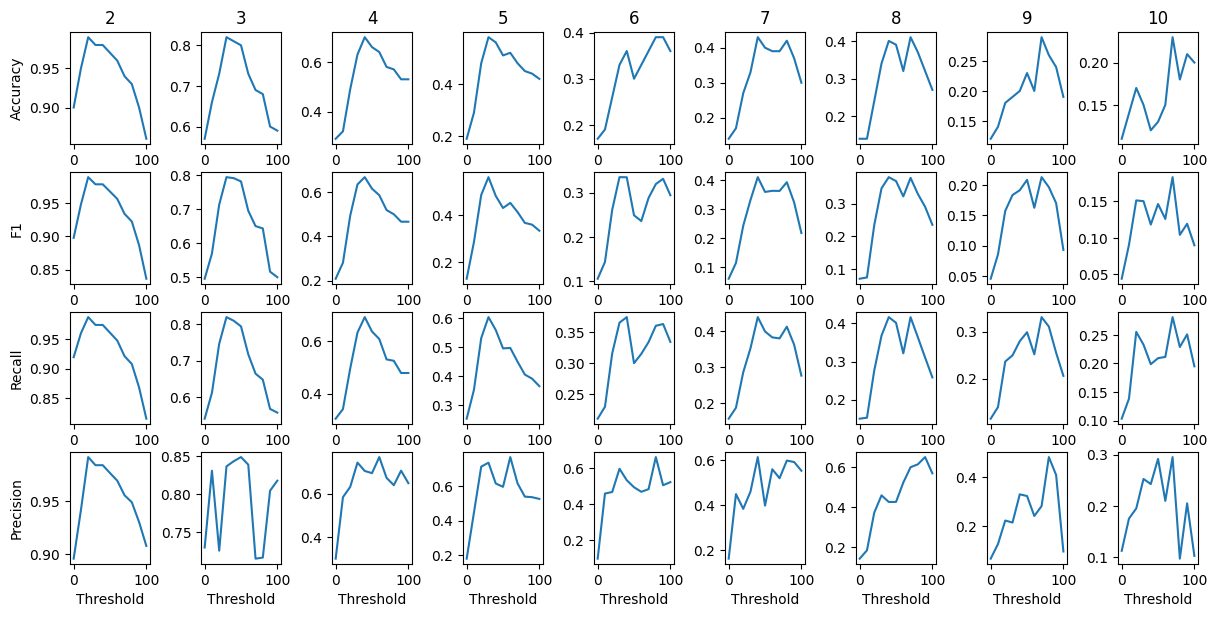

rule: hebb, energy: exp, update: async


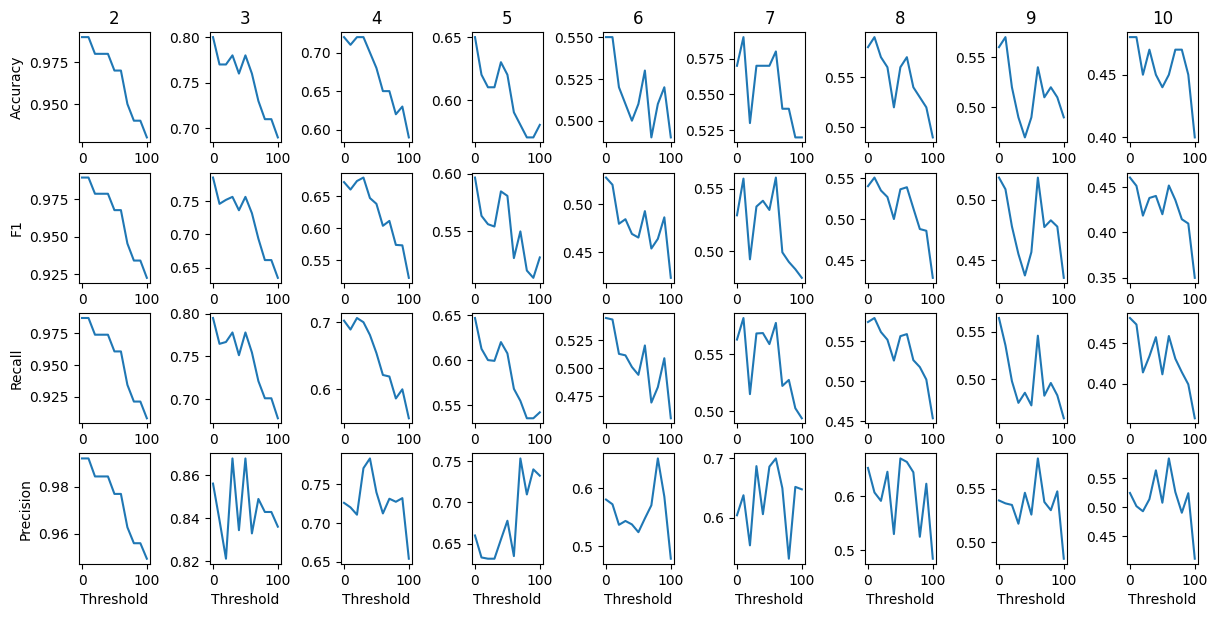

rule: hebb, energy: classic, update: sync


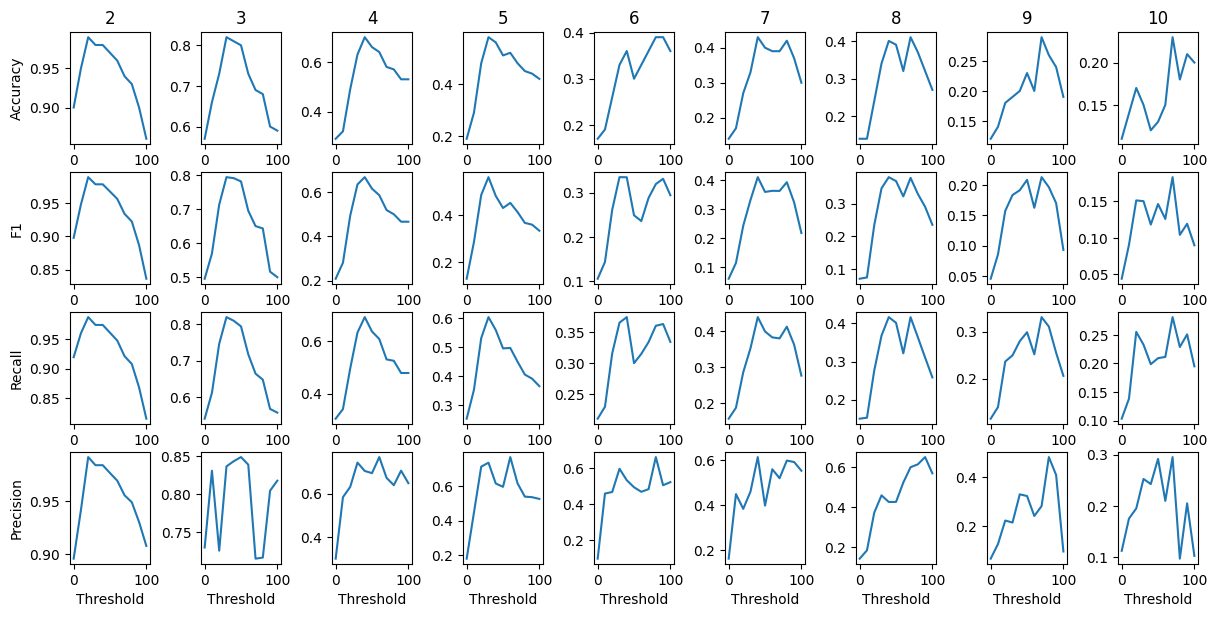

rule: hebb, energy: classic, update: async


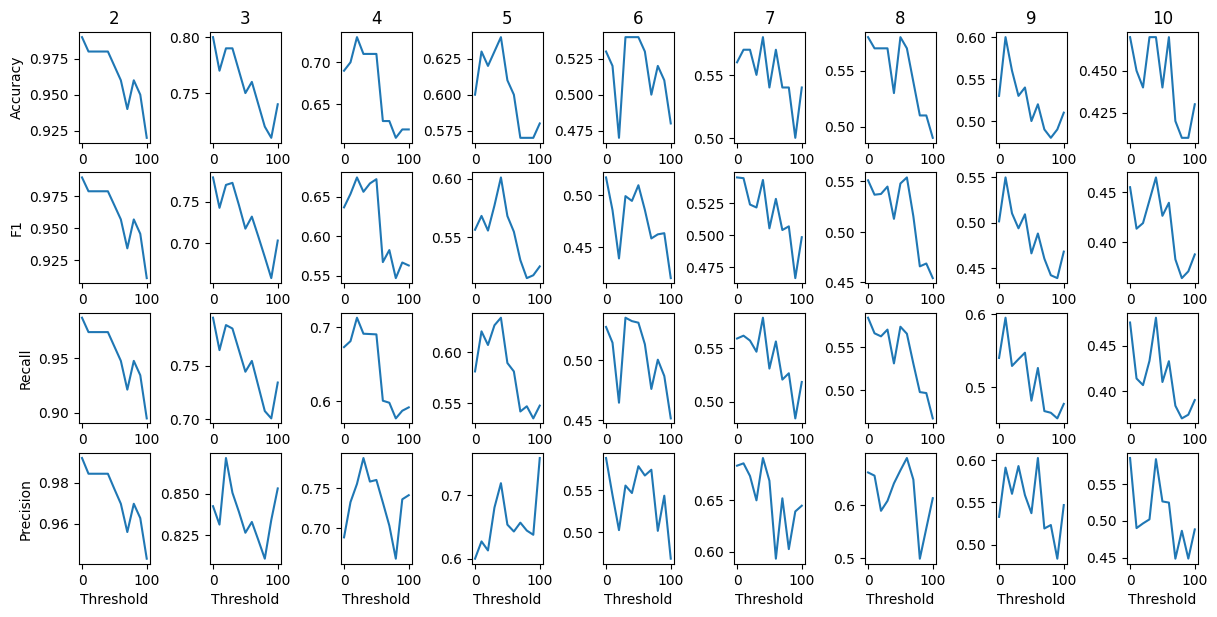

rule: storkey, energy: exp, update: sync


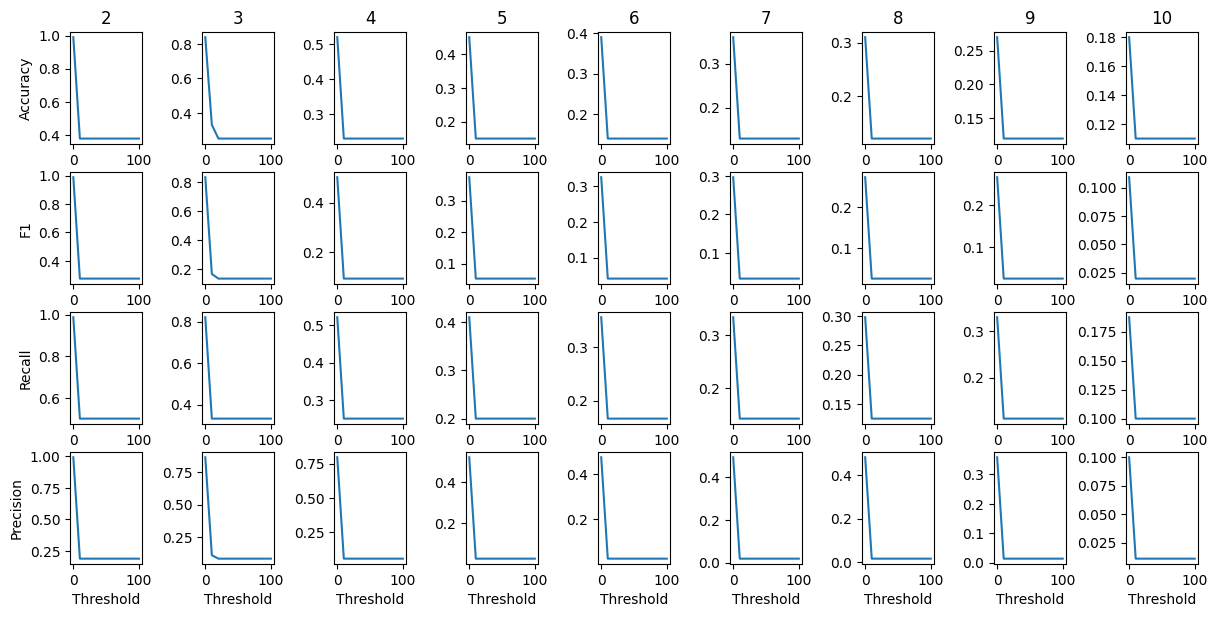

rule: storkey, energy: exp, update: async


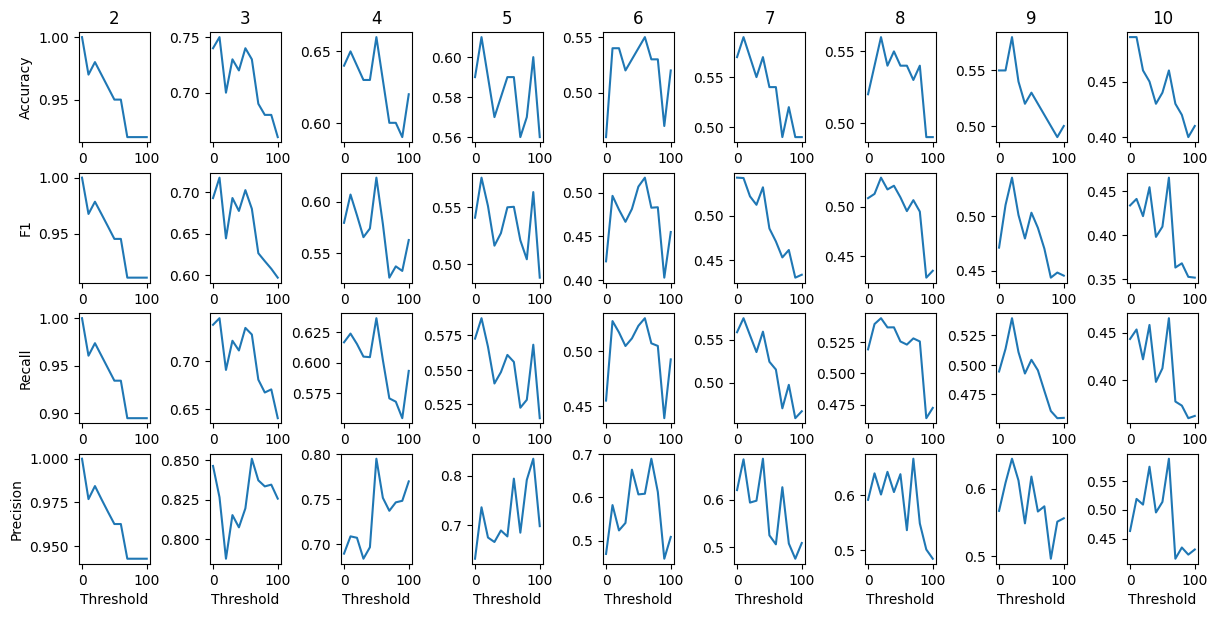

rule: storkey, energy: classic, update: sync


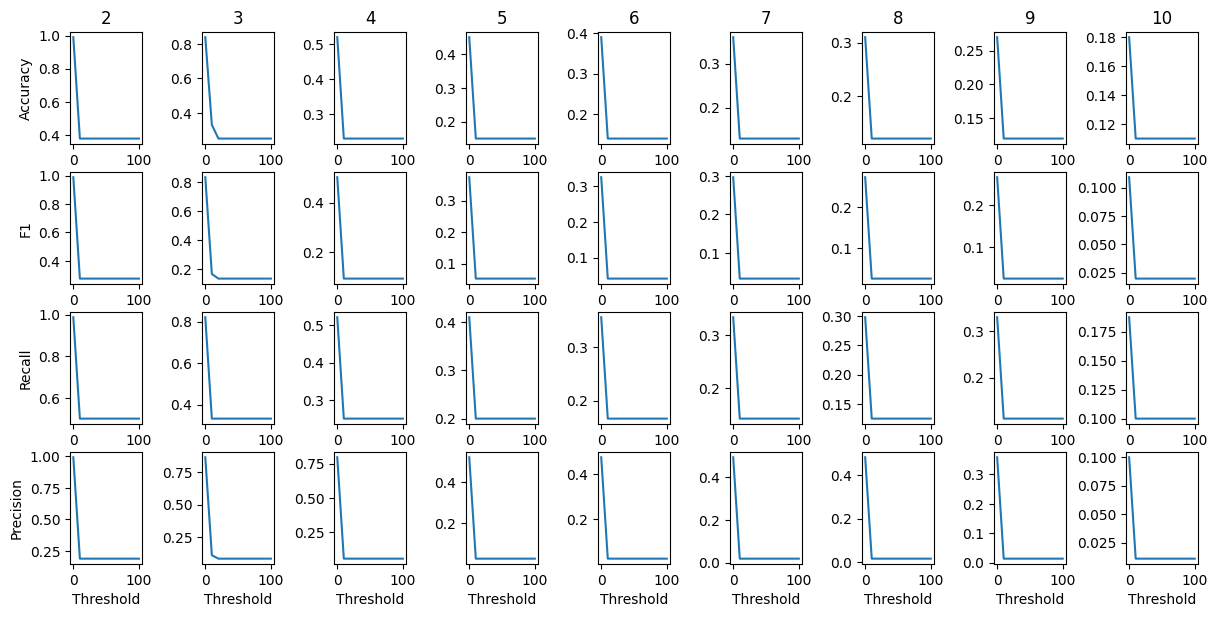

rule: storkey, energy: classic, update: async


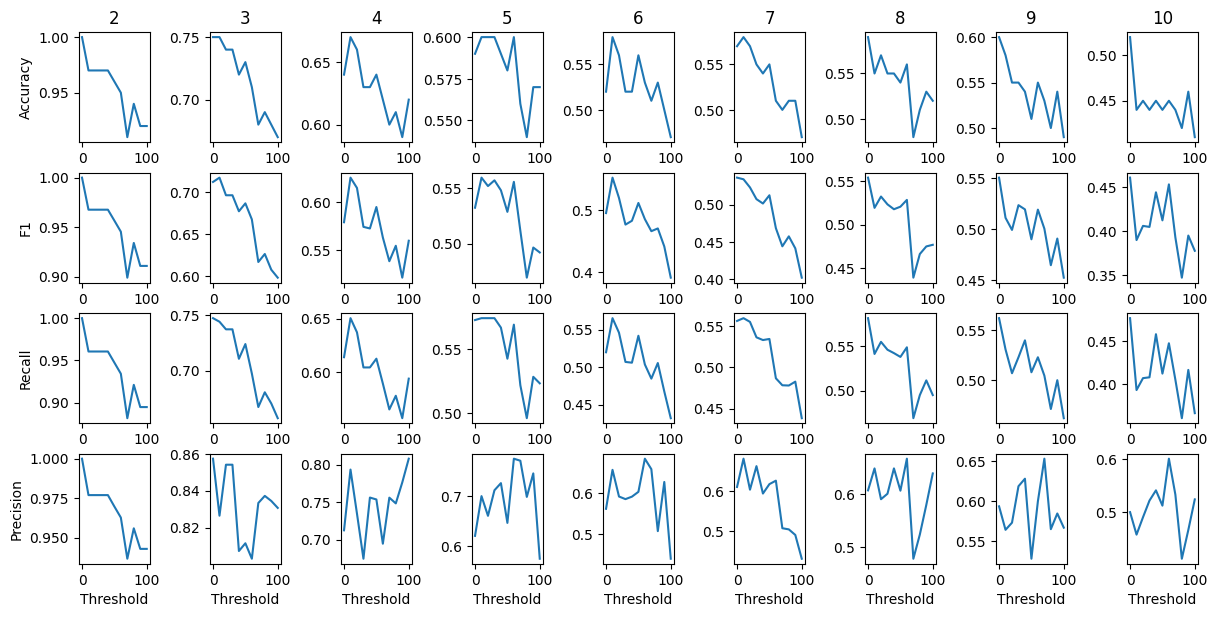

rule: demircigil, energy: exp, update: demircigil


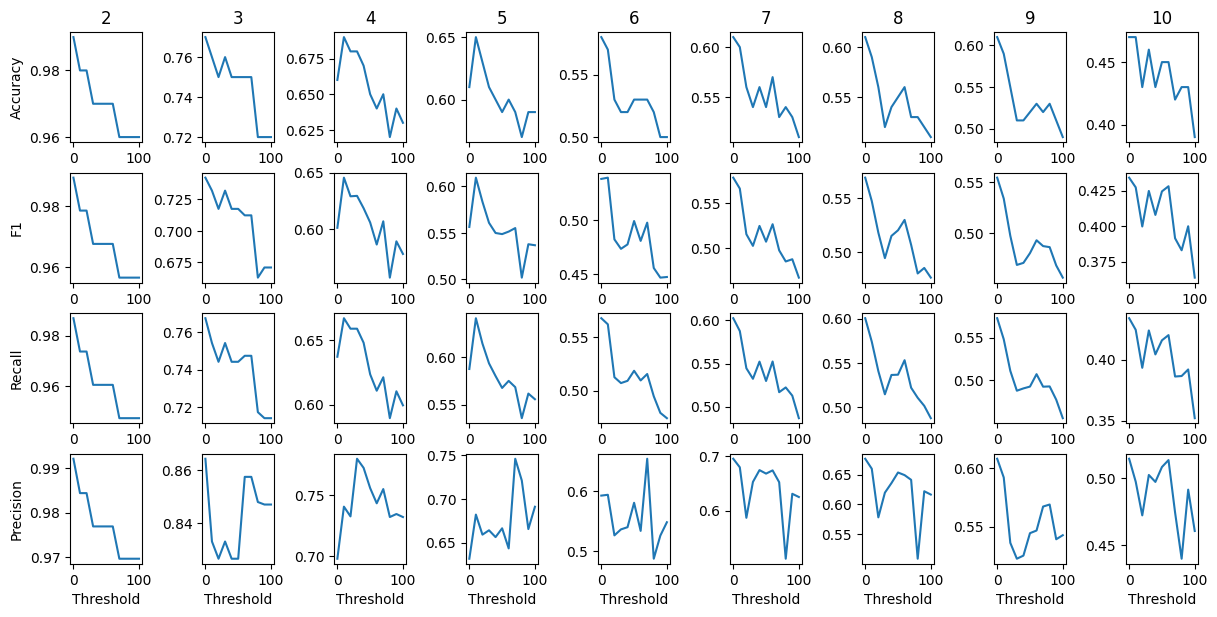

In [8]:
def visualize_dict_metrics(history):
    metric_names = ['Accuracy', 'F1', 'Recall', 'Precision']
    
    for rule, energies_dict in history.items():
        for energy, updates_dict in energies_dict.items():
            for update, labels_dict in updates_dict.items(): 
                if len(list(labels_dict.items())[0][1]) == 0:
                    continue

                print(f'rule: {rule}, energy: {energy}, update: {update}')
                fig = plt.figure(figsize=(12, 6))

                for label, metrics in labels_dict.items(): 
                    offset = label - 2

                    plt.subplot(4, 9, 1 + offset)
                    plt.plot(metrics.keys(), [metric[0] for metric in metrics.values()], label=f'{update} - {metric_names[0]}')
                    plt.title(f'{label}')
                    if label == 2:
                        plt.ylabel(metric_names[0])

                    plt.subplot(4, 9, 10 + offset)
                    plt.plot(metrics.keys(), [metric[1] for metric in metrics.values()], label=f'{update} - {metric_names[1]}')
                    if label == 2:
                        plt.ylabel(metric_names[1])

                    plt.subplot(4, 9, 19 + offset)
                    plt.plot(metrics.keys(), [metric[2] for metric in metrics.values()], label=f'{update} - {metric_names[2]}')
                    if label == 2:
                        plt.ylabel(metric_names[2])

                    plt.subplot(4, 9, 28 + offset)
                    plt.plot(metrics.keys(), [metric[3] for metric in metrics.values()], label=f'{update} - {metric_names[3]}')
                    if label == 2:
                        plt.ylabel(metric_names[3])
                    plt.xlabel('Threshold')

                fig.tight_layout(pad=0.1)
                plt.show()


visualize_dict_metrics(history)

Predicted labels are coming directly from predicted images, which are produced by the Hopfield network by comparing to memory-cached training data. 

As we can see overall accuracy and macro metrics are falling down when we increase the number of classes and patterns. This can be explained by the fact that MNIST numbers can have high autocorrelation which may often result in an undefined state or wrong memory extracted.

We can make next conclusions:
* only the hebb rule needs threshold tuning - other methods effectiveness declines with threshold set > 0
* without special demircigil update exponential energy roughly matches classic energy
* storkey works worse than hebb in current scenario
* even with demircigil which is proven to be able to effectively work with great number of patterns there is no great results with relatively small set of patterns
* async updates can be on par with demircigil - how?

The reason async updates can be so much better than sync is that they are less likely to converge (less steps set for them) which leads to basically classification by distance.

While demircigil can be improved by giving more examples to it, so overall it's better

Other way to improve the model - better preprocessing (removing autocorrelating border around characters and selecting the best references)




 Storkey - sync
(10, 784)
Predicted value = 9, actual label = 7


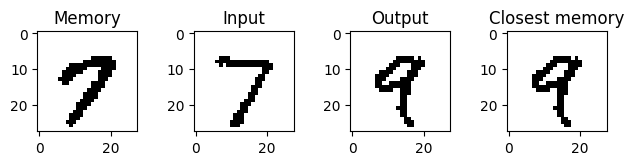

Predicted value = 9, actual label = 2


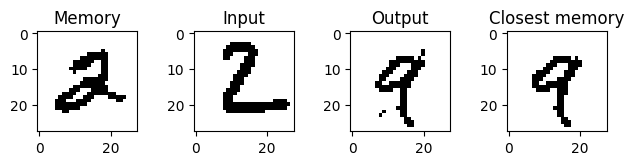

Predicted value = 9, actual label = 1


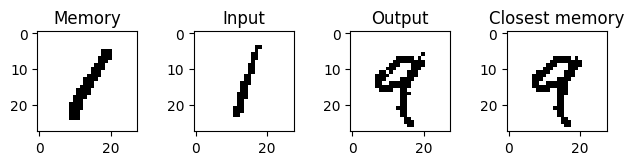

Predicted value = 0, actual label = 0


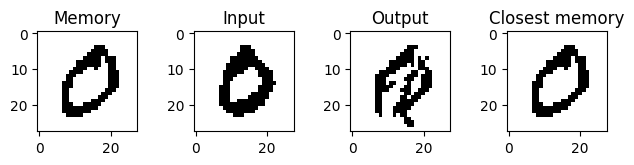

Predicted value = 9, actual label = 4


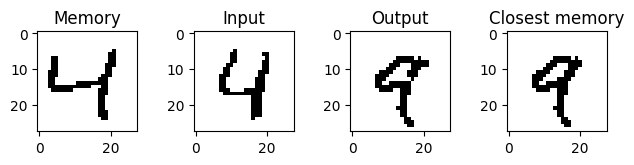

(0.2, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666)



 Storkey - async
(10, 784)
Predicted value = 7, actual label = 7


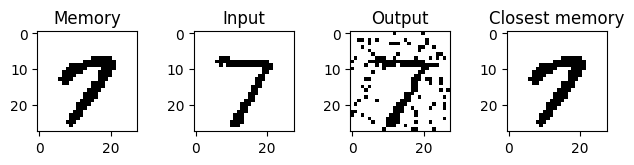

Predicted value = 1, actual label = 2


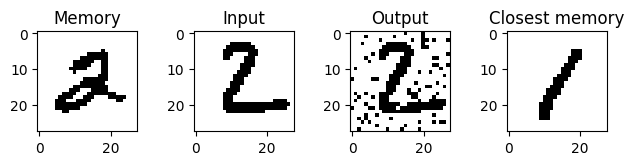

Predicted value = 1, actual label = 1


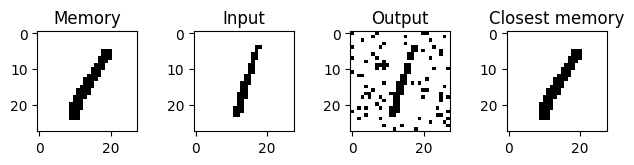

Predicted value = 0, actual label = 0


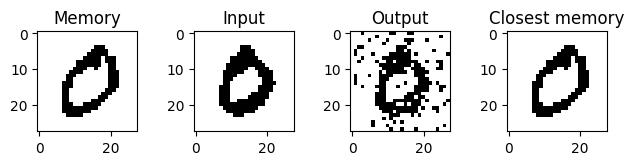

Predicted value = 4, actual label = 4


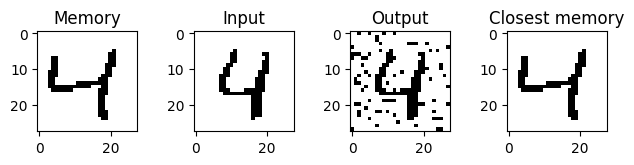

(0.8, 0.7333333333333333, 0.8, 0.7)



 Demircigil - small train set
(10, 784)
Predicted value = 7, actual label = 7


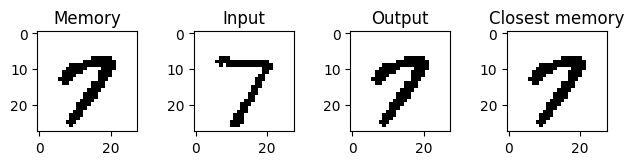

Predicted value = 1, actual label = 2


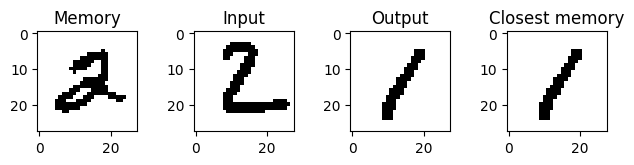

Predicted value = 1, actual label = 1


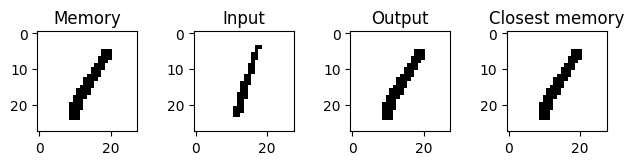

Predicted value = 0, actual label = 0


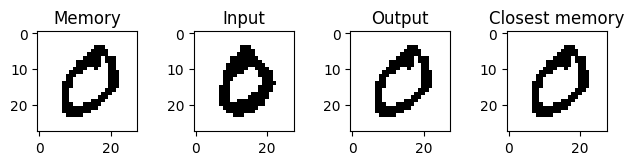

Predicted value = 4, actual label = 4


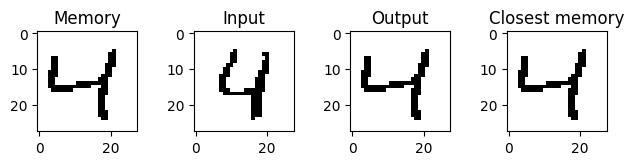

(0.8, 0.7333333333333333, 0.8, 0.7)



 Demircigil - big train set
(20, 784)
Predicted value = 14, actual label = 7


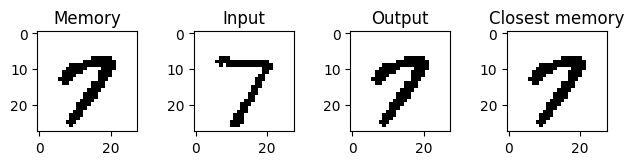

Predicted value = 13, actual label = 2


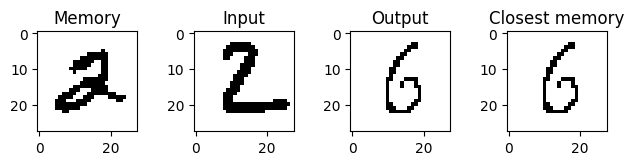

Predicted value = 2, actual label = 1


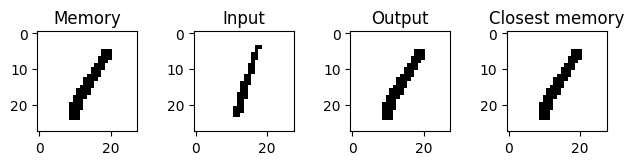

Predicted value = 0, actual label = 0


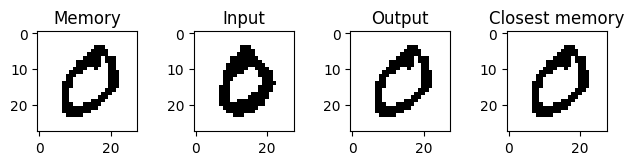

Predicted value = 8, actual label = 4


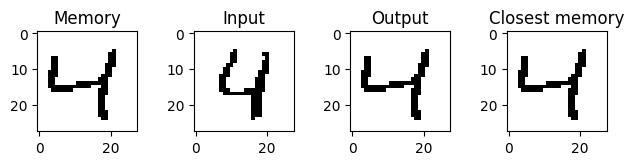

(0.8, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666)


In [9]:
train, test = get_input(threshold, 10)

print("\n\n\n Storkey - sync")
metrics = train_and_visualize(train, test, range(0, 10), hide_charts=False, test_len=5, learning_rule='storkey', energy_function='classic', update_function='sync', threshold=0)
print(metrics)

print("\n\n\n Storkey - async")
metrics = train_and_visualize(train, test, range(0, 10), hide_charts=False, test_len=5, learning_rule='storkey', energy_function='classic', update_function='async', threshold=0)
print(metrics)

print("\n\n\n Demircigil - small train set")
metrics = train_and_visualize(train, test, range(0, 10), hide_charts=False, test_len=5, learning_rule='demircigil', energy_function='exp', update_function='demircigil', threshold=0)
print(metrics)

print("\n\n\n Demircigil - big train set")
metrics = train_and_visualize(train, test, range(0, 10), hide_charts=False, test_len=5, references_per_class=2, learning_rule='demircigil', energy_function='exp', update_function='demircigil', threshold=0)
print(metrics)